# Churn Rate Prediction

In [1]:
import numpy as np
import pandas as pd
import gc

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## 1. Explaratory Data Analysis

### 1.1. Data Reading

In [2]:
train = pd.read_csv('orange_small_churn_data.txt')
labels = pd.read_csv('orange_small_churn_labels.txt', header = None, names = ['churn'])

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 230 entries, Var1 to Var230
dtypes: float64(191), int64(1), object(38)
memory usage: 70.2+ MB


In [4]:
labels

,churn
0,-1
1,-1
2,-1
3,1
4,-1
...,...
39995,-1
39996,-1
39997,-1
39998,-1


In [5]:
labels.loc[labels.churn == -1, 'churn'] = 0

In [6]:
data = pd.concat([train, labels], axis = 1)

In [7]:
labels.churn.value_counts()

0    37024
1     2976
Name: churn, dtype: int64

Calculating the classes weights:

In [8]:
print('Churn (1) class share:', labels[labels.churn == 1].count() / labels.shape[0])
print('Non-churn (0) class share:', labels[labels.churn == 0].count() / labels.shape[0])

Churn (1) class share: churn    0.0744
dtype: float64
Non-churn (0) class share: churn    0.9256
dtype: float64


In [9]:
features_num = train.columns[0:190].tolist()
features_cat = train.columns[190:230].tolist()

In [10]:
train[features_cat] = train[features_cat].astype(object)

### 1.1 Numerical Features Correlations Calculating

Calculating the Spearman's correlation in order to determine the correlation between numerical features and the target function.

In [11]:
data[features_num].corrwith(other = data.churn, method = 'spearman').sort_values(ascending = False).head(10)

Var53     0.119918
Var3      0.095864
Var188    0.095375
Var129    0.086110
Var41     0.067387
Var126    0.066427
Var19     0.065095
Var156    0.064839
Var66     0.064839
Var183    0.064685
dtype: float64

Correlation between the numerical values (top-20):

In [12]:
num_corr = data[features_num].corr(method = 'spearman').sort_values('Var1', ascending = False, axis = 0)\
.sort_values('Var1', ascending = False, axis = 1).iloc[:10, :10]

num_corr

,Var1,Var63,Var41,Var66,Var156,Var9,Var180,Var154,Var12,Var187
Var1,1.000000,0.694561,0.684517,0.652416,0.652416,0.652027,0.575860,0.564477,0.506863,0.457520
Var63,0.694561,1.000000,0.600786,0.879734,0.879734,0.879645,0.534094,0.417977,0.663473,0.655468
Var41,0.684517,0.600786,1.000000,0.730939,0.730939,0.730965,0.700442,0.863676,0.417042,0.558883
Var66,0.652416,0.879734,0.730939,1.000000,1.000000,0.999961,0.616162,0.518679,0.595911,0.851054
Var156,0.652416,0.879734,0.730939,1.000000,1.000000,0.999961,0.616162,0.518679,0.595911,0.851054
Var9,0.652027,0.879645,0.730965,0.999961,0.999961,1.000000,0.616124,0.520706,0.596957,0.851479
Var180,0.575860,0.534094,0.700442,0.616162,0.616162,0.616124,1.000000,0.780158,0.445697,0.523483
Var154,0.564477,0.417977,0.863676,0.518679,0.518679,0.520706,0.780158,1.000000,0.270026,0.361879
Var12,0.506863,0.663473,0.417042,0.595911,0.595911,0.596957,0.445697,0.270026,1.000000,0.429917
Var187,0.457520,0.655468,0.558883,0.851054,0.851054,0.851479,0.523483,0.361879,0.429917,1.000000


Visualizing the top-20 correlated numerical features.

In [13]:
import seaborn as sns

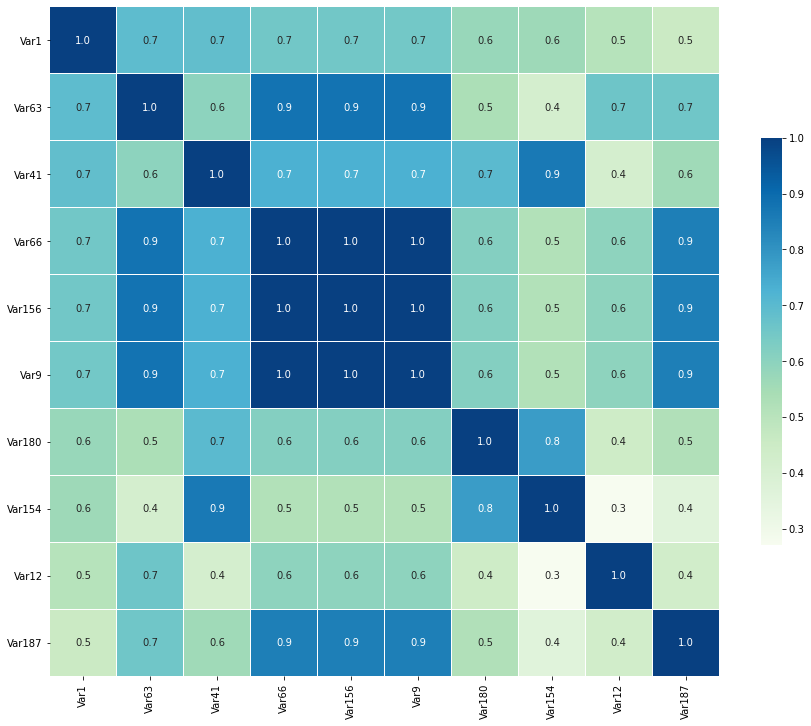

Wall time: 520 ms


In [14]:
%%time

sns.heatmap(num_corr, annot = True, cmap = 'GnBu', linewidths = .2, square = True, fmt = '.1f', cbar_kws = {'shrink':.5})
fig = plt.gcf()
fig.set_size_inches(15,15)
plt.show()

### 1.3 Categorical Features Correlation Calculating

In [15]:
from scipy.stats import chi2_contingency

In [16]:
# function, Calculating the Cramer's coefficient
def cramer(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [17]:
# calling the 'cramer' function
data_cat = train[features_cat]
cramers = []

for col in features_cat:
    if data_cat[col].isnull().sum() != len(data_cat): # if not nan
        cramers.append(cramer(data_cat[col], labels['churn']))
    else:
        cramers.append(np.nan)
        
cat_corr = pd.DataFrame(zip(features_cat, cramers), columns = ['feature', 'cramer'])
cat_corr.set_index('feature', inplace = True)
cat_corr.sort_values(by = 'cramer', inplace = True, ascending = False)  
cat_corr.dropna(inplace = True)
cat_corr.head(10)

,cramer
feature,
Var199,0.237375
Var192,0.116264
Var216,0.083442
Var206,0.077436
Var212,0.075150
Var205,0.073484
Var228,0.070617
Var193,0.060861
Var207,0.055418


### 1.4 Plotting the dependency between train sample size and base score using `learning_curve`

In [18]:
from sklearn.model_selection import learning_curve, cross_val_score, StratifiedKFold
from xgboost import XGBClassifier

In [19]:
X = train[features_num].copy()
X = X.fillna(X.mean())
X = X.dropna(axis=1,how='all')
X = pd.DataFrame(X)

y = labels['churn']

Using `learning_curve` from `scikit-learn`, the train dataset shape and train score dependency is plotted.

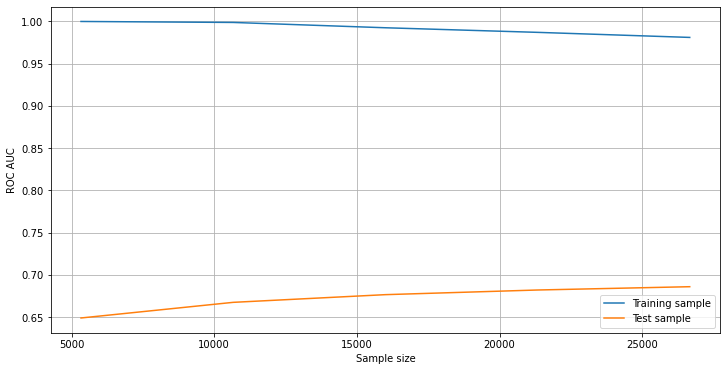

In [20]:
clf = XGBClassifier()
train_sizes, train_scores, test_scores = learning_curve(clf, X, y, cv=3, scoring='roc_auc', train_sizes=[0.2, 0.4, 0.6, 0.8, 1])
plt.figure(figsize=(12,6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training sample')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test sample')
plt.xlabel('Sample size')
plt.ylabel('ROC AUC')
plt.legend()
plt.grid()
plt.show()

As it can be seen from the plot, the quality rise is insignificant.

In [21]:
del(data)
gc.collect()

2904

## 2. Feature Engineering

The model score at each experiment is evaluated using F1 and ROC-AUC scores, as this scorers are useful for imbalanced classes.

As the classifier, `XGBoost` algorithm is used.

In [22]:
# function calculating score at cross validation
def cv_score(clf, X, y, scoring):
    return cross_val_score(clf, X, y, cv = StratifiedKFold(), scoring = scoring, n_jobs = -1).mean()

### 2.1. Choosing the null values threshold

In [23]:
feat_thr = []
for threshold in range(0, 40000, 1000):
    feat_thr.append(train.loc[:, train.isna().sum() > threshold].shape[1])

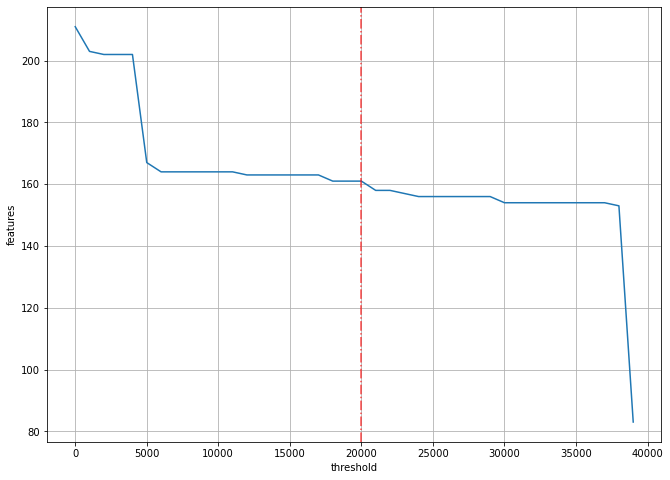

In [24]:
plt.figure(figsize = (11,8))
plt.plot(range(0,40000,1000), feat_thr)
plt.xlabel('threshold')
plt.ylabel('features')
plt.axvline(20000, color = 'red', ls = '-.', alpha = 0.7)
plt.grid()
plt.show()

The threshold value of 20,000 seems reasonable.

### 2.2. Numerical features handling techniques

In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
# function filling na with 'fill' parameter
def fill_real(fill, X, returning=False):
    X = X.fillna(fill)    
    
    # using Standard Scaler
    X = pd.DataFrame(StandardScaler().fit_transform(X))
    
    print('ROC-AUC:', cv_score(clf, X, y, 'roc_auc'))
    print('F1-score:', cv_score(clf, X, y, 'f1'))
    
    if returning:
        return X

In [27]:
X = train[features_num].dropna(axis=1,how='all')

# removing columns with more than 20000 null features
X = X.loc[:, X.isna().sum() < 20000]

y = labels['churn']

In [28]:
fill_real(0, X)

ROC-AUC: 0.6759709763811387
F1-score: 0.04029513600959615


In [29]:
fill_real(X.mean(), X)

ROC-AUC: 0.6749908333822341
F1-score: 0.042500745036642876


In [30]:
fill_real(X.median(), X)

ROC-AUC: 0.6633859557396299
F1-score: 0.04159673569902448


Filling NA with mean values shows the best trade-off between ROC-AUC and F1 score.

In [31]:
X_num = fill_real(X.mean(), X, True)

ROC-AUC: 0.6749908333822341
F1-score: 0.042500745036642876


### 2.3. Categorical features handling techniques

In [32]:
from sklearn.preprocessing import OneHotEncoder

In [33]:
# dropping all zero columns
X = train[features_cat].dropna(axis=1,how='all')

# removing columns with more than 20000 null features
X = X.loc[:, X.isna().sum() < 20000]

# filling NA with 'NULL'
X.fillna('NULL', inplace = True)

Applying OneHotEncoder technique to encode the categorical values:

In [34]:
X_cols_before_ohe = X.columns.tolist()

In [35]:
%%time

ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
X_ohe = pd.DataFrame(ohe.fit_transform(X))

del(X)
gc.collect()

Wall time: 1.23 s


3141

### 2.4 Concatenating the numerical and categorical features

In [36]:
del([train, labels])
gc.collect()

20

In [37]:
X = pd.concat([X_num, X_ohe], axis=1)

In [38]:
del([X_num, X_ohe])
gc.collect()

40

In [39]:
X.shape

(40000, 36934)

### 2.5 Selecting the best features

In [40]:
from sklearn.feature_selection import SelectKBest

In [41]:
%%time

sel_1500 = SelectKBest(k = 1500)
sel_1500.fit(X, y)

print('ROC-AUC:', cv_score(clf, X.loc[:, sel_1500.get_support()], y, 'roc_auc'))
print('F1-score:', cv_score(clf, X.loc[:, sel_1500.get_support()], y, 'f1'))

ROC-AUC: nan
F1-score: nan
Wall time: 7min 46s


In [42]:
%%time
sel_500 = SelectKBest(k = 500)
sel_500.fit(X, y)
print('ROC-AUC:', cv_score(clf, X.loc[:, sel_500.get_support()], y, 'roc_auc'))
print('F1-score:', cv_score(clf, X.loc[:, sel_500.get_support()], y, 'f1'))

ROC-AUC: 0.7147660502393581
F1-score: 0.0714974508413477
Wall time: 9min 44s


As the result shows, only 500 best parameters can be kept for future use.

In [43]:
X = X.loc[:, sel_500.get_support()]

## 3\. Dataset Handling (classes weights, oversampling)

### 3.1. Setting the objects weights, so that the classes ratio is taken into account

In [44]:
# basic classifier
clf = XGBClassifier()
print('ROC-AUC:', cv_score(clf, X, y, 'roc_auc'))
print('F1-score:', cv_score(clf, X, y, 'f1'))

ROC-AUC: 0.7147660502393581
F1-score: 0.0714974508413477


In [45]:
# XGBoost with classes ratio
clf = XGBClassifier(scale_pos_weight = 12.44)
print('ROC-AUC:', cv_score(clf, X, y, 'roc_auc'))
print('F1-score:', cv_score(clf, X, y, 'f1'))

ROC-AUC: 0.7154573845603152
F1-score: 0.2377747195204058


In [46]:
# XGBoost with wrong classes ratio
clf = XGBClassifier(scale_pos_weight = 6.22)
print('ROC-AUC:', cv_score(clf, X, y, 'roc_auc'))
print('F1-score:', cv_score(clf, X, y, 'f1'))

ROC-AUC: 0.7233157300640884
F1-score: 0.26556260074735966


Unexpectedly, the best result within the conducted experiments can be seen at `scale_pos_weight` parameter equaling 6.
For this reason, trying to apply undersampling and oversampling technique.

### 3.2. Applying undersampling technique

In [47]:
print(X.shape, y.shape)

(40000, 500) (40000,)


In [48]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_rus, y_rus = rus.fit_sample(X, y)

In [49]:
print(X_rus.shape, y_rus.shape)

(5952, 500) (5952,)


In [50]:
clf = XGBClassifier()
print('ROC-AUC:', cv_score(clf, X_rus, y_rus, 'roc_auc'))
print('F1-score:', cv_score(clf, X_rus, y_rus, 'f1'))

ROC-AUC: 0.6999730415656196
F1-score: 0.6379641523483495


The undersampling slightly decreases the model score. The F1 score is higher, because now the samples are of equal size.

### 3.3. Applying oversampling technique

In [51]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_ros, y_ros = ros.fit_sample(X, y)

In [52]:
print(X_ros.shape, y_ros.shape)

(74048, 500) (74048,)


In [53]:
clf = XGBClassifier()
print('ROC-AUC:', cv_score(clf, X_ros, y_ros, 'roc_auc'))
print('F1-score:', cv_score(clf, X_ros, y_ros, 'f1'))

ROC-AUC: 0.8670430373532619
F1-score: 0.788075106457058


The oversampling significantly highers both the ROC-AUC and F1 score. 

For the future operations, the oversampled data will be used.

In [54]:
X, y = X_ros, y_ros

del([X_rus, y_rus, X_ros, y_ros])
gc.collect()

294

### 3.4. Splitting the dataset

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y)

## 4.  Classification Model

### 4.1. Learning Algorithm Hyperparameters Grid Search

In [56]:
from sklearn.model_selection import GridSearchCV

In [57]:
X = X_train.values
y = y_train.values

The GridSearchCV algorithm was called several times, and during the experiments the best hyperparameters values were obtained. However, I left this piece of code here just for explicity reasons.

In [58]:
%%time
clf = XGBClassifier()

param_grid = {'max_depth':[13, 15], 'n_estimators':[250, 300], 'learning_rate':[0.03]}

xgb = GridSearchCV(clf, param_grid, scoring = 'roc_auc', cv = 3, n_jobs = -1)

xgb.fit(X, y)

print('Best params', xgb.best_params_)
print('Best score', xgb.best_score_)

Best params {'learning_rate': 0.03, 'max_depth': 15, 'n_estimators': 300}
Best score 0.9786178788723356
Wall time: 21min 55s


As the optimal hyperparameters values were obtained, the model perforamnce can be cross-validated on test subset.

### 4.2. Cross-validation

In [64]:
from sklearn.model_selection import cross_val_score

In [60]:
%%time
cross_val_score(xgb.best_estimator_, X_test, y_test, cv = 3, n_jobs = -1, scoring = 'roc_auc').mean()

Wall time: 3min 59s


0.945070199480527

In [61]:
%%time
cross_val_score(xgb.best_estimator_, X_test, y_test, cv = 3, n_jobs = -1, scoring = 'f1').mean()

Wall time: 4min 2s


0.8855024200610727

Taking a look at feature importances - what features contributed most to the model. 

In [62]:
pd.DataFrame({'feature':X_train.columns.to_list(), 'weight':xgb.best_estimator_.feature_importances_}).sort_values('weight', ascending = False)

,feature,weight
129,14677,0.017423
168,21211,0.014054
9,28,0.013174
14,148,0.011434
312,29920,0.009386
...,...,...
348,31157,0.000000
142,15808,0.000000
189,26406,0.000000
351,31558,0.000000


## Summary

During the project, the following data processing techniques were used and tested:
* numerical features processing (filling missing values, scaling - `StandardScaler`);
* categorical features processing (filling missing values, encoding - `OneHotEncoder`);
* concatenated preprocessed numerical and categorical best features selection (`SelectKBest`);
* sampling techniques (under- and over-sampling algorithms from `imblearn` library).

The model (`XGBClassifier`) optimal hyperparameters (`max_depth`, `n_estimators`, `learning_rate`) were found using Grid Search technique (`GridSearchCV`).

The benchmark score was 0.9256 (the major class weight). This value was overcome at cross-validation test.

The resulting score of the model built and set up is:
* ROC-AUC: 0.945
* F1: 0.88